# LLM Lab: Prompt Engineering Evaluation
## Supply Chain Optimization Domain

This notebook evaluates how prompt phrasing, structure, and constraints influence LLM response quality.

**Team Roles:**
- Prompt Architect
- Evaluation Engineer
- Safety & Mitigation Analyst
- MLOps Integrator
- Technical Communicator

## Setup & Configuration

In [19]:
# Install dependencies if needed
# !pip install -r ../requirements.txt

In [20]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.insert(0, '..')

from src.llm_clients import LLMClient, load_config
from src.prompts import PromptBuilder
from src.evaluator import ResponseEvaluator, create_evaluation_summary
from src.visualizations import generate_all_visualizations

# Set your API key
# Option 1: Set in environment
# os.environ['GOOGLE_API_KEY'] = 'your-api-key-here'

# Option 2: Already set via terminal export

In [21]:
# Load configuration
config = load_config('../config/experiment_config.yaml')
print(f"Domain: {config['experiment']['domain']}")
print(f"Model: {config['models']['primary']['name']}")
print(f"Temperature: {config['models']['primary']['parameters']['temperature']}")

Domain: supply_chain_optimization
Model: gemini-2.0-flash
Temperature: 0.7


## Task 1: Design Prompt Variants

We test 5 distinct prompt designs:
1. **P1_direct** - Naive, no constraints
2. **P2_constrained** - Explicit format requirements
3. **P3_role_based** - Expert persona
4. **P4_reasoning_step** - Chain-of-Thought
5. **P5_context_first** - Context before instruction

In [22]:
# Build all prompts
prompt_builder = PromptBuilder('../config/experiment_config.yaml')
prompts_table = prompt_builder.get_prompts_table()

# Display prompt variants table
df_prompts = pd.DataFrame(prompts_table)
df_prompts

,Variant ID,Name,Description,Prompt Preview
0,P1_direct,Direct/Naive,Simple question with no constraints or structure,How do I optimize inventory levels for a manuf...
1,P2_constrained,Constrained,Explicit constraints and format requirements,How do I optimize inventory levels for a manuf...
2,P3_role_based,Role-Based,Assign expert persona to the model,You are a senior supply chain consultant with ...
3,P4_reasoning_step,Chain-of-Thought,Explicit step-by-step reasoning request,How do I optimize inventory levels for a manuf...
4,P5_context_first,Context-First,Provide context before the question,Context:\nWe are a mid-sized electronics manuf...


In [23]:
# Preview a specific prompt (e.g., Chain-of-Thought)
print("=" * 60)
print("P4 Reasoning Step (CoT) Prompt:")
print("=" * 60)
print(prompt_builder.build_prompt('P4_reasoning_step'))

P4 Reasoning Step (CoT) Prompt:
How do I optimize inventory levels for a manufacturing facility with seasonal demand patterns?

Think through this step-by-step:
1. First, analyze the key factors affecting inventory decisions
2. Then, identify the appropriate inventory model
3. Next, explain how to calculate optimal levels
4. Finally, provide implementation recommendations

Show your reasoning for each step.


## Run Experiments

Execute each prompt variant and collect responses.

In [24]:
# Initialize LLM client
client = LLMClient(config)
print(f"Using model: {client.get_model_info()}")

Using model: {'provider': 'google', 'model': 'gemini-2.0-flash'}


In [25]:
# Run all prompt variants
responses = {}
all_prompts = prompt_builder.build_all_prompts()

for variant_id, data in all_prompts.items():
    print(f"Running {variant_id}: {data['name']}...")
    try:
        result = client.generate(data['prompt'])
        responses[variant_id] = {
            'name': data['name'],
            'description': data['description'],
            'prompt': data['prompt'],
            'response': result['response'],
            'token_count': result['token_count'],
            'latency_ms': result['latency_ms']
        }
        print(f"  ✓ Completed ({result['token_count']} tokens, {result['latency_ms']}ms)")
    except Exception as e:
        print(f"  ✗ Error: {e}")
        responses[variant_id] = {'error': str(e)}

print(f"\nCompleted {len([r for r in responses.values() if 'response' in r])}/{len(all_prompts)} variants")

Running P1_direct: Direct/Naive...
  ✓ Completed (851 tokens, 9451.0ms)
Running P2_constrained: Constrained...
  ✓ Completed (339 tokens, 3614.93ms)
Running P3_role_based: Role-Based...
  ✓ Completed (850 tokens, 7500.15ms)
Running P4_reasoning_step: Chain-of-Thought...
  ✓ Completed (887 tokens, 8032.31ms)
Running P5_context_first: Context-First...
  ✓ Completed (894 tokens, 7535.97ms)

Completed 5/5 variants


In [26]:
# View a sample response
sample_variant = 'P1_direct'
if sample_variant in responses and 'response' in responses[sample_variant]:
    print(f"Response from {sample_variant}:")
    print("=" * 60)
    print(responses[sample_variant]['response'])

Response from P1_direct:
Optimizing inventory levels for a manufacturing facility with seasonal demand requires a multifaceted approach. Here's a breakdown of strategies, focusing on planning, forecasting, execution, and monitoring:

**1. Demand Forecasting & Planning:**

*   **Historical Data Analysis:**
    *   **Gather Data:** Collect at least 3-5 years of historical sales data, ideally broken down by month or week.  Include data on promotions, pricing changes, competitor actions, and any external factors (weather events, economic shifts) that might have impacted demand.
    *   **Identify Trends:** Look for recurring seasonal patterns. Calculate seasonal indices (e.g., the average demand for January compared to the average demand for the entire year).  Use statistical analysis (regression, time series analysis) to quantify these patterns.
    *   **Clean and Adjust Data:**  Remove outliers (e.g., due to one-time promotions). Adjust past data to reflect any significant changes in yo

## Task 2: Evaluate Limitations and Mitigations

Analyze responses for:
- Factual hallucinations
- Logical inconsistencies
- Overconfidence
- Missing key details
- Over-elaboration

In [27]:
# Initialize evaluator
evaluator = ResponseEvaluator('../config/experiment_config.yaml')

# Evaluate all responses
evaluations = {}

for variant_id, data in responses.items():
    if 'response' in data:
        eval_result = evaluator.full_evaluation(
            response=data['response'],
            token_count=data['token_count']
        )
        evaluations[variant_id] = eval_result
        
        # Print summary
        summary = eval_result['summary']
        print(f"{variant_id}: Accuracy={summary['accuracy_score']}/2, "
              f"Completeness={summary['completeness_pct']}%, "
              f"Issues={summary['issue_count']}")

P1_direct: Accuracy=2/2, Completeness=50.0%, Issues=1
P2_constrained: Accuracy=2/2, Completeness=66.7%, Issues=1
P3_role_based: Accuracy=2/2, Completeness=66.7%, Issues=1
P4_reasoning_step: Accuracy=2/2, Completeness=50.0%, Issues=1
P5_context_first: Accuracy=2/2, Completeness=50.0%, Issues=1


In [28]:
# Detailed failure analysis for one variant
analyze_variant = 'P1_direct'
if analyze_variant in evaluations:
    failures = evaluations[analyze_variant]['failure_behaviors']
    print(f"\nFailure Analysis for {analyze_variant}:")
    print("-" * 40)
    for issue in failures['issues']:
        print(f"• [{issue['severity']}] {issue['type']}")
        print(f"  {issue['description']}")


Failure Analysis for P1_direct:
----------------------------------------
• [Low] Over-elaboration
  Response is 655 words, potentially too verbose


### Mitigation Strategies

Based on observed failures, we can apply:
1. **Chain-of-Thought (CoT)** - For reasoning improvement
2. **Source Checking Requests** - "Cite sources" instruction
3. **Confidence Calibration** - "Express uncertainty where appropriate"
4. **Output Validation** - "Verify your answer is complete"

In [29]:
# Document mitigation observations
mitigation_notes = """
## Observed Issues & Mitigations

| Issue | Mitigation | Variant that helps |
|-------|------------|-------------------|
| Overconfidence | Add uncertainty language request | P4_reasoning_step |
| Missing details | Explicit checklist in prompt | P2_constrained |
| Over-elaboration | Word count limits | P2_constrained |
| Hallucination | Request reasoning steps | P4_reasoning_step |

### Key Insight:
Add your team's observations here after running experiments.
"""
print(mitigation_notes)


## Observed Issues & Mitigations

| Issue | Mitigation | Variant that helps |
|-------|------------|-------------------|
| Overconfidence | Add uncertainty language request | P4_reasoning_step |
| Missing details | Explicit checklist in prompt | P2_constrained |
| Over-elaboration | Word count limits | P2_constrained |
| Hallucination | Request reasoning steps | P4_reasoning_step |

### Key Insight:
Add your team's observations here after running experiments.



## Task 3: Quantitative and Qualitative Evaluation

In [30]:
# Create summary table
summary_rows = create_evaluation_summary(evaluations)
df_summary = pd.DataFrame(summary_rows)
df_summary

,Variant,Accuracy (0-2),Completeness (%),Token Count,Issues Found,Clarity (1-5)
0,P1_direct,2,50.0,851,1,None
1,P2_constrained,2,66.7,339,1,None
2,P3_role_based,2,66.7,850,1,None
3,P4_reasoning_step,2,50.0,887,1,None
4,P5_context_first,2,50.0,894,1,None


In [31]:
# Add peer clarity ratings (manual input)
# Team members should rate each response 1-5 on clarity

# Example: Fill these in after peer review
clarity_ratings = {
    'P1_direct': 3,
    'P2_constrained': 4,
    'P3_role_based': 4,
    'P4_reasoning_step': 5,
    'P5_context_first': 4
}

# Update evaluations with clarity scores
for variant_id, rating in clarity_ratings.items():
    if variant_id in evaluations:
        evaluations[variant_id]['clarity_score'] = rating

All visualizations saved to ../results/


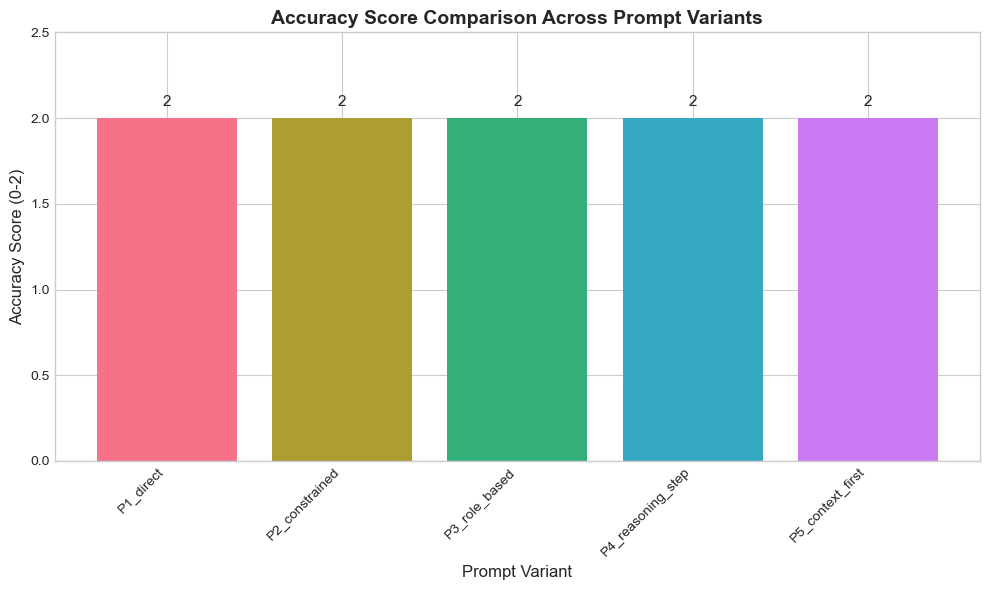

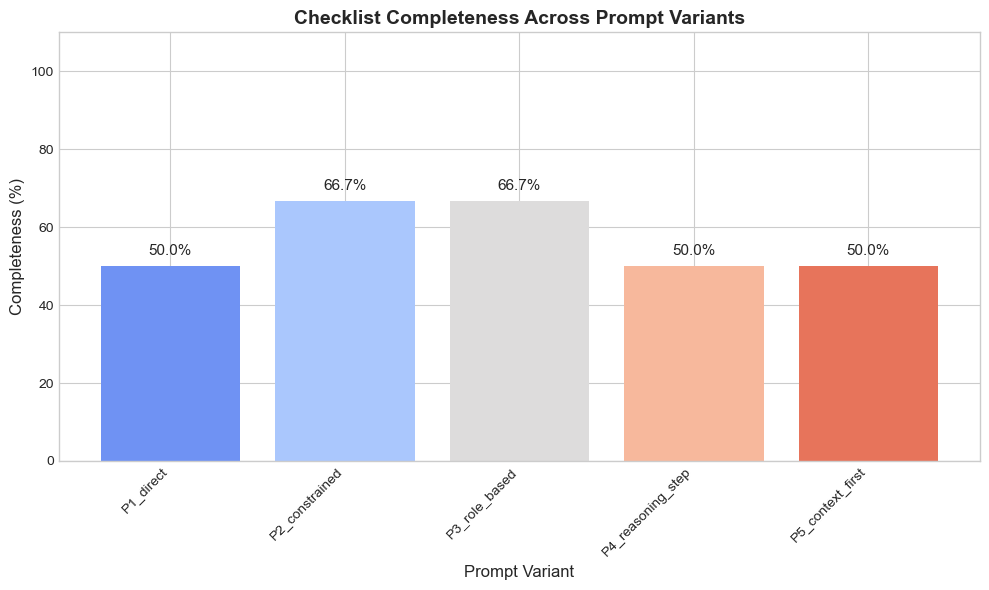

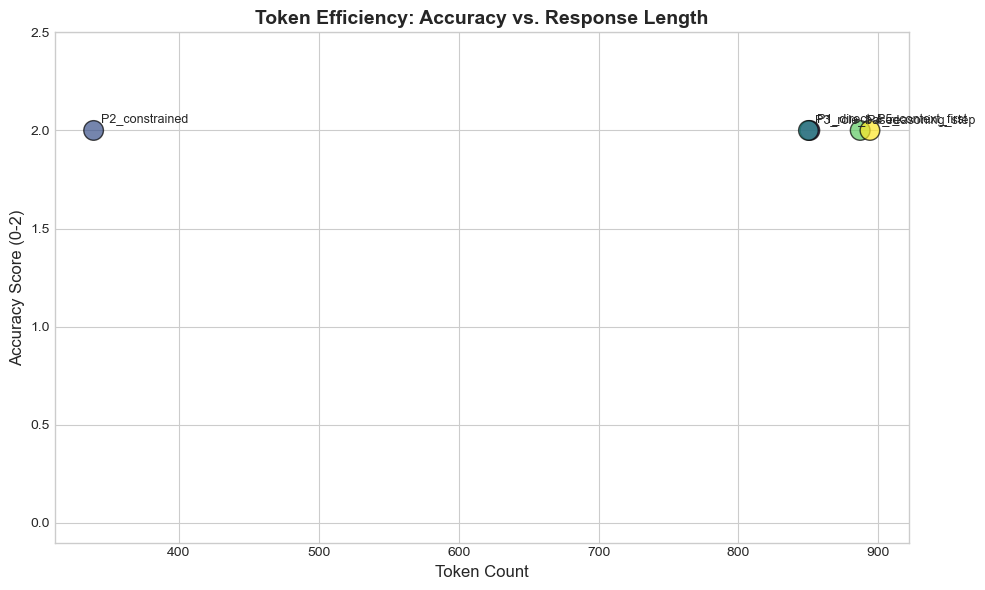

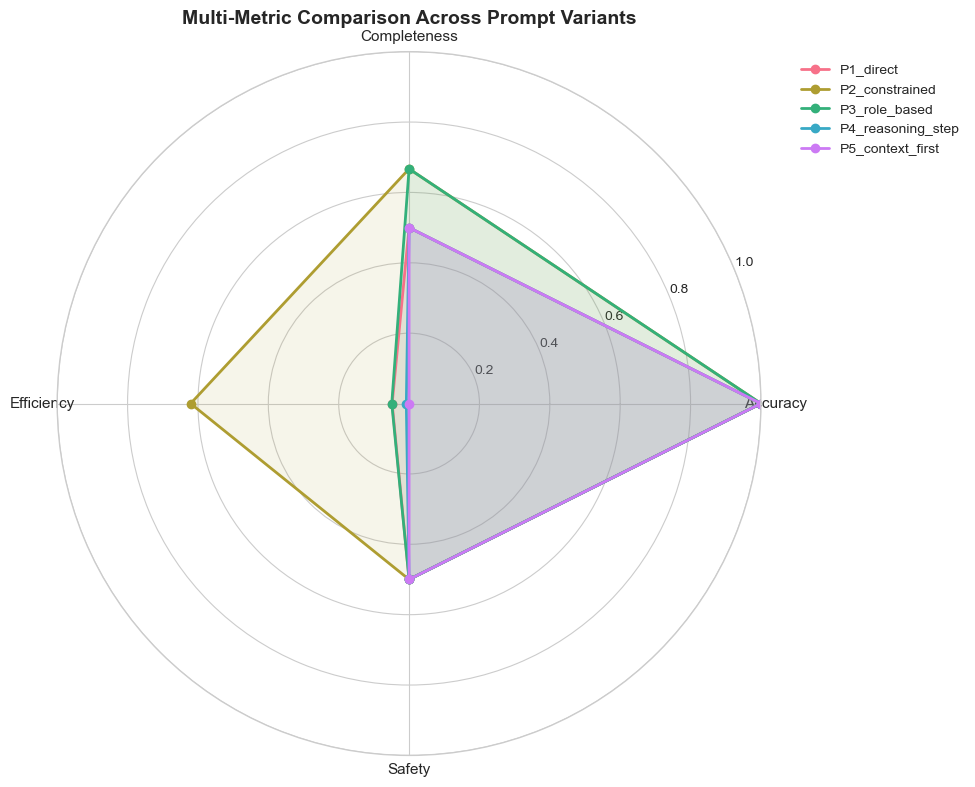

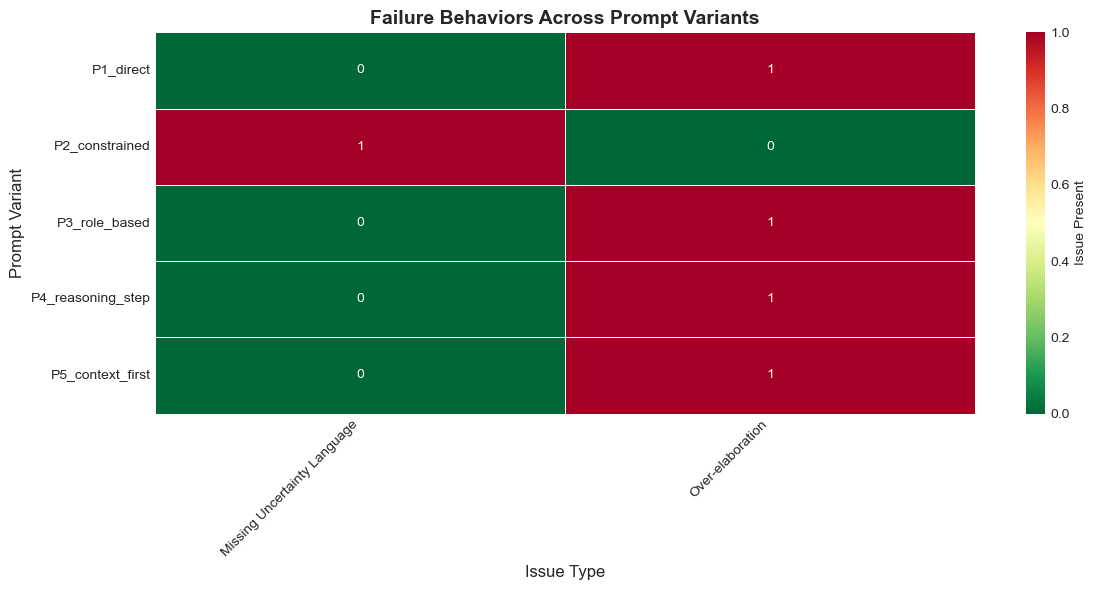

In [32]:
# Generate all visualizations
import os
os.makedirs('../results', exist_ok=True)

figs = generate_all_visualizations(evaluations, '../results')
plt.show()

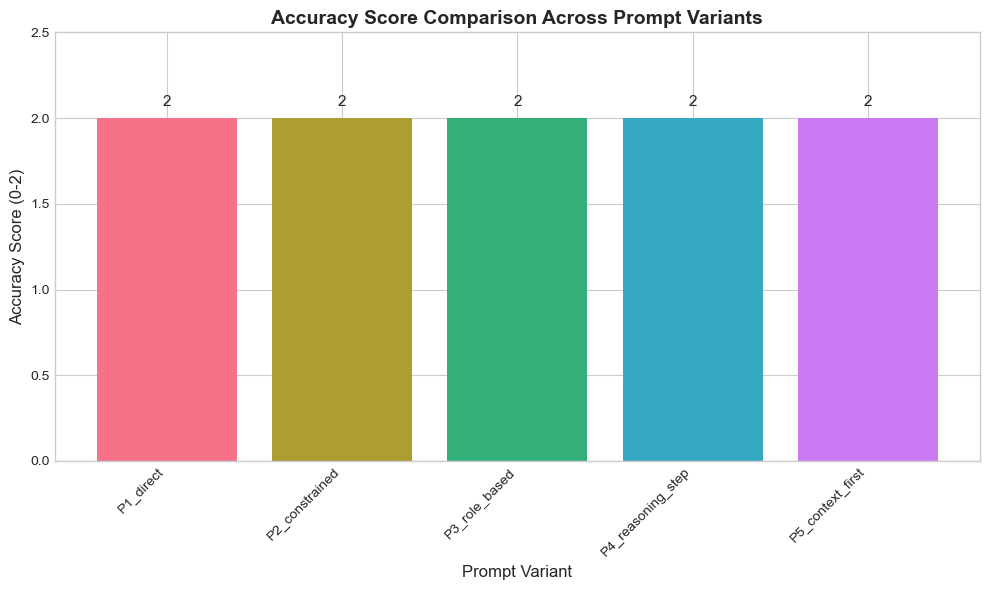

In [33]:
# Display accuracy comparison
from src.visualizations import plot_accuracy_comparison
plot_accuracy_comparison(evaluations)
plt.show()

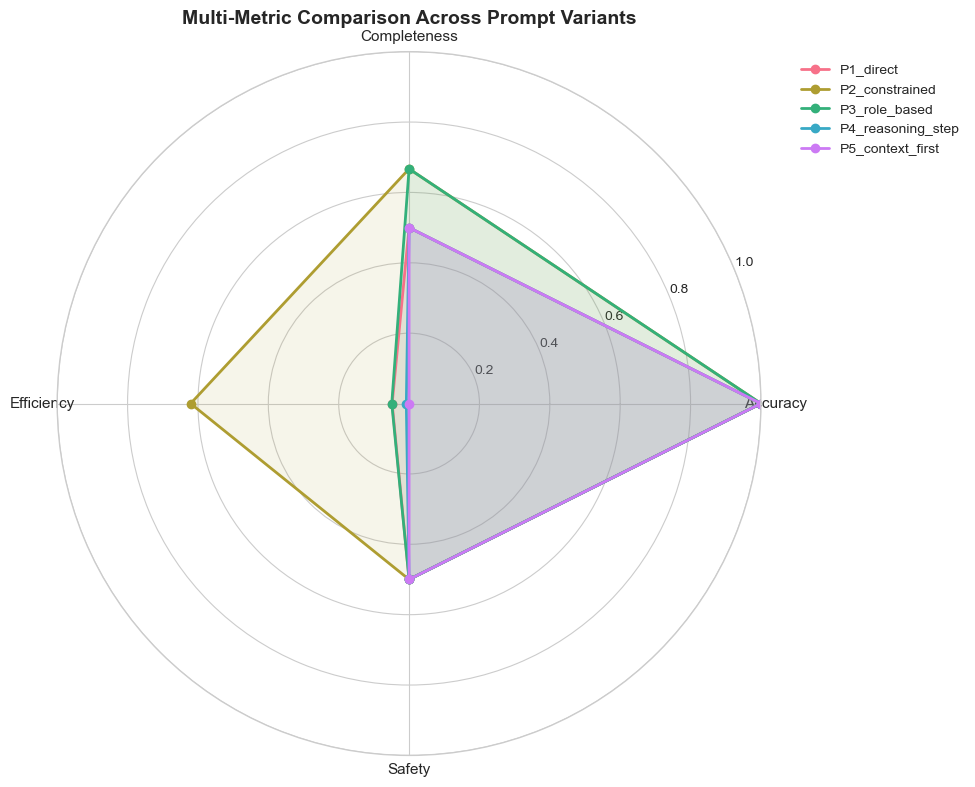

In [34]:
# Display radar chart
from src.visualizations import plot_radar_chart
plot_radar_chart(evaluations)
plt.show()

## Connection to Few-Shot and RAG

**How these prompting techniques scale:**

1. **Few-Shot Prompting**: Add examples to P2_constrained or P4_reasoning_step
2. **Retrieval-Augmented Generation (RAG)**: P5_context_first naturally extends to RAG by
   replacing static context with retrieved documents
3. **Production Systems**: Use structured output (P2) + reasoning (P4) + dynamic context (P5)

In [35]:
# Example: Few-shot extension of P2_constrained
few_shot_prompt = """
Here is an example of a well-structured inventory optimization answer:

Example Query: How to manage inventory for a retail store?
Example Answer:
1. Implement ABC analysis to prioritize high-value items
2. Use EOQ formula: √(2DS/H) where D=demand, S=order cost, H=holding cost
3. Set reorder point: Lead time demand + Safety stock
4. Monitor with KPIs: turnover ratio, stockout rate
5. Review quarterly and adjust for seasonality

Now answer the following using the same structure:

{query}
"""

print("Few-shot prompt template created.")
print("This extends P2_constrained with a concrete example.")

Few-shot prompt template created.
This extends P2_constrained with a concrete example.


## Save Results

In [36]:
# Save responses to JSON for reproducibility
import json

with open('../results/responses.json', 'w') as f:
    json.dump(responses, f, indent=2)

with open('../results/evaluations.json', 'w') as f:
    # Convert to serializable format
    serializable_evals = {k: v for k, v in evaluations.items()}
    json.dump(serializable_evals, f, indent=2)

print("Results saved to ../results/")

Results saved to ../results/


## Summary & Next Steps

### Key Findings (Fill in after experiments):
1. Best overall prompt variant: _____
2. Most common failure mode: _____
3. Most effective mitigation: _____

### Recommendations:
- For accuracy: Use _____
- For efficiency: Use _____
- For production: Combine _____ + _____